
**Key Steps Include:**

1. Calculating 6M/12M risk-adjusted momentum
2. Standardization and winsorization of Z-score
3. Also,deriving a composite momentum value it starts after collecting 3 years of weekly data so i started from 2021.







MSCI MOMENTUM STRATEGY - INDIAN MARKET (NIFTY 50)
This may take a while...

 Nifty 50 index downloaded

Progress: 10/50 stocks processed...
Progress: 20/50 stocks processed...
Progress: 30/50 stocks processed...
Progress: 40/50 stocks processed...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TATAMOTORS.NS']: YFTzMissingError('possibly delisted; no timezone found')


Progress: 50/50 stocks processed...

Successfully downloaded: 49/50 stocks
Failed stocks (1): TATAMOTORS


Running backtest with 15 stocks, rebalancing 6ME...
Rebalancing dates: 10

Rebalancing 1/10: 2021-02-01
 Insufficient data for momentum calculation

Rebalancing 2/10: 2021-07-30
 Insufficient data for momentum calculation

Rebalancing 3/10: 2022-01-31
 Insufficient data for momentum calculation

Rebalancing 4/10: 2022-08-01
 Insufficient data for momentum calculation

Rebalancing 5/10: 2023-01-31
 Insufficient data for momentum calculation

Rebalancing 6/10: 2023-07-31
 Insufficient data for momentum calculation

Rebalancing 7/10: 2024-01-31
 Insufficient data for momentum calculation

Rebalancing 8/10: 2024-07-31
 Insufficient data for momentum calculation

Rebalancing 9/10: 2025-01-31
  Selected 15 stocks
  Kept from previous: 0

Rebalancing 10/10: 2025-07-31
 Insufficient data for momentum calculation

 Backtest complete: 123 return observations

PERFORMANCE METRICS

Total Retu

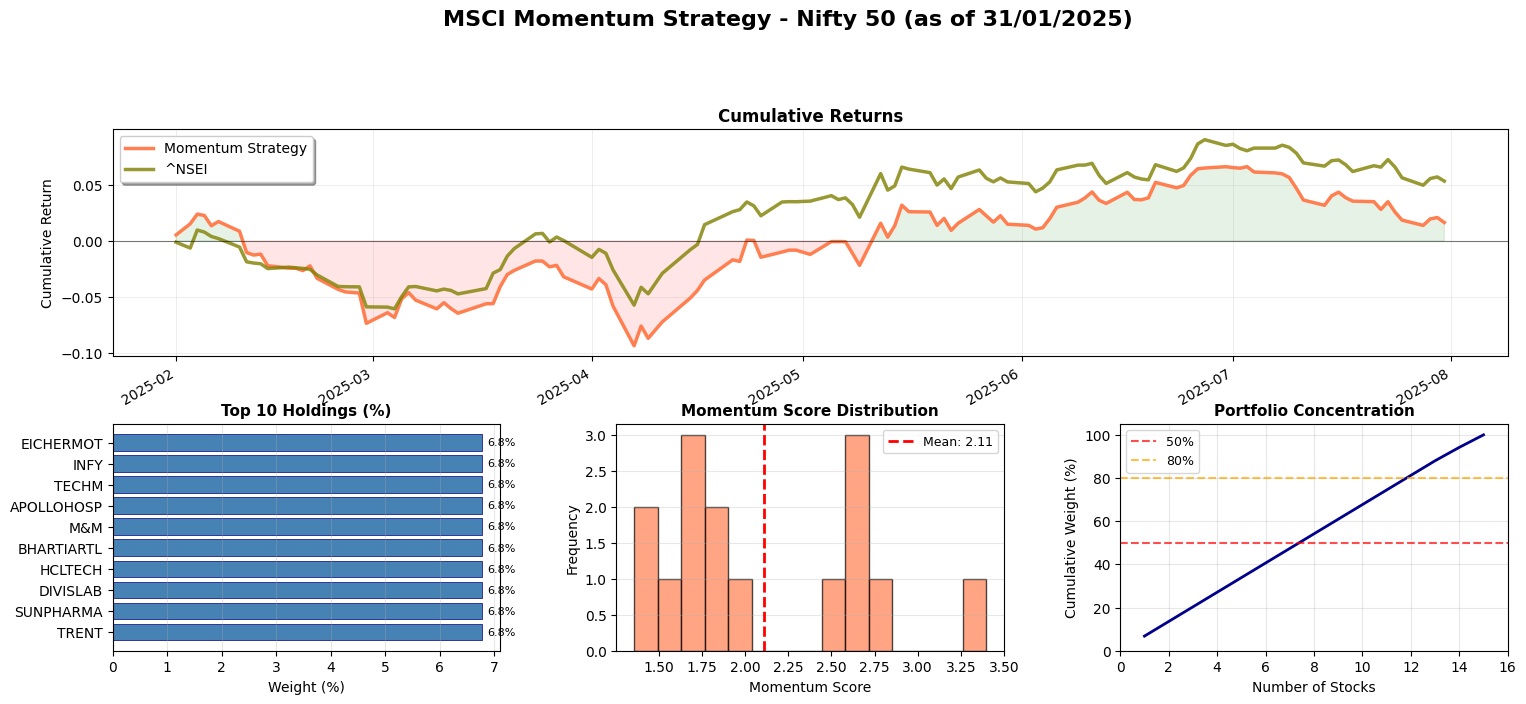

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# India-specific risk-free rate (3M MIBOR approximately 6.5%)
RISK_FREE_RATE = 0.065

class MSCIMomentumIndia:
    def __init__(self, start_date="2021-01-01"):
        self.start_date = start_date
        self.rf_rate = RISK_FREE_RATE
        self.symbols = self._get_nifty50_symbols()
        self.prices = pd.DataFrame()
        self.nifty_index = None
        self.portfolio_returns = None
        self.rebalance_dates = []
        self.holdings_history = {}

    def _get_nifty50_symbols(self):
        symbols = [
            'RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'HINDUNILVR.NS',
            'ICICIBANK.NS', 'KOTAKBANK.NS', 'SBIN.NS', 'BHARTIARTL.NS', 'ITC.NS',
            'BAJFINANCE.NS', 'ASIANPAINT.NS', 'MARUTI.NS', 'HCLTECH.NS', 'AXISBANK.NS',
            'SUNPHARMA.NS', 'ULTRACEMCO.NS', 'TITAN.NS', 'NESTLEIND.NS', 'WIPRO.NS',
            'LT.NS', 'TECHM.NS', 'NTPC.NS', 'ONGC.NS', 'POWERGRID.NS', 'BAJAJFINSV.NS',
            'M&M.NS', 'TATASTEEL.NS', 'ADANIPORTS.NS', 'HINDALCO.NS', 'INDUSINDBK.NS',
            'COALINDIA.NS', 'DIVISLAB.NS', 'BRITANNIA.NS', 'EICHERMOT.NS', 'DRREDDY.NS',
            'GRASIM.NS', 'JSWSTEEL.NS', 'HEROMOTOCO.NS', 'CIPLA.NS', 'BAJAJ-AUTO.NS',
            'TATACONSUM.NS', 'APOLLOHOSP.NS', 'BPCL.NS', 'SBILIFE.NS', 'HDFCLIFE.NS',
            'TATAMOTORS.NS', 'SHRIRAMFIN.NS', 'TRENT.NS', 'ADANIENT.NS'
        ]
        return symbols

    def download_data(self):
        print(f"Downloading data for {len(self.symbols)} Nifty 50 stocks...")
        print("This may take a while...\n")

        # Download Nifty 50 index
        try:
            print("Downloading Nifty 50 index...")
            nifty_data = yf.download('^NSEI', start=self.start_date, progress=False)
            self.nifty_index = nifty_data['Adj Close'] if 'Adj Close' in nifty_data.columns else nifty_data['Close']
            print(" Nifty 50 index downloaded\n")
        except Exception as e:
            print(f" Error downloading Nifty index: {e}\n")

        # Download individual stocks
        successful = 0
        failed = []

        for i, symbol in enumerate(self.symbols, 1):
            try:
                data = yf.download(symbol, start=self.start_date, progress=False)

                if not data.empty:
                    # Extract closing price
                    if 'Adj Close' in data.columns:
                        self.prices[symbol] = data['Adj Close']
                    elif 'Close' in data.columns:
                        self.prices[symbol] = data['Close']
                    else:
                        # Handle multi-level columns
                        if isinstance(data.columns, pd.MultiIndex):
                            self.prices[symbol] = data['Close'][symbol] if symbol in data['Close'].columns else data['Close'].iloc[:, 0]
                        else:
                            self.prices[symbol] = data.iloc[:, 0]

                    successful += 1
                    if i % 10 == 0:
                        print(f"Progress: {i}/{len(self.symbols)} stocks processed...")
                else:
                    failed.append(symbol)

            except Exception as e:
                failed.append(symbol)
                print(f"Failed to download {symbol}: {str(e)[:50]}")

        # Cleaning the extracted data
        self.prices = self.prices.dropna(how='all', axis=1)

        print(f"\n{'='*60}")
        print(f"Successfully downloaded: {successful}/{len(self.symbols)} stocks")
        if failed:
            print(f"Failed stocks ({len(failed)}): {', '.join([s.replace('.NS', '') for s in failed[:5]])}")
        print(f"{'='*60}\n")

        return self.prices

    def calculate_momentum_scores(self, as_of_date):
        hist_prices = self.prices.loc[:as_of_date]

        if len(hist_prices) < 365:
            return pd.DataFrame()

        # Calculate 3-year volatility using weekly returns
        weekly_prices = hist_prices.resample('W-FRI').last().ffill()
        weekly_returns = weekly_prices.pct_change()
        vol_3y = weekly_returns.rolling(window=156).std() * np.sqrt(52)

        p_t1 = hist_prices.shift(21)   # 1 month ago
        p_t7 = hist_prices.shift(147)  # 7 months ago (for 6M momentum)
        p_t13 = hist_prices.shift(273) # 13 months ago (for 12M momentum)

        # Calculate price momentum (excess of risk-free rate)
        mom_6m = (p_t1 / p_t7 - 1) - (self.rf_rate * 0.5)
        mom_12m = (p_t1 / p_t13 - 1) - self.rf_rate

        # Calculate risk-adjusted momentum
        risk_adj_mom_6m = mom_6m / vol_3y
        risk_adj_mom_12m = mom_12m / vol_3y

        # Get latest values
        latest_ram_6m = risk_adj_mom_6m.iloc[-1]
        latest_ram_12m = risk_adj_mom_12m.iloc[-1]

        # Calculate z-scores
        z_6m = (latest_ram_6m - latest_ram_6m.mean()) / latest_ram_6m.std()
        z_12m = (latest_ram_12m - latest_ram_12m.mean()) / latest_ram_12m.std()

        # Combine z-scores (equal weight)
        z_combined = 0.5 * z_6m + 0.5 * z_12m

        # Winsorize at +/- 3
        z_final = z_combined.clip(-3, 3)

        # Convert to momentum score
        momentum_score = np.where(
            z_final >= 0,
            1 + z_final,
            1 / (1 - z_final)    )

        # Create results dataframe
        results = pd.DataFrame({
            'mom_6m': mom_6m.iloc[-1],
            'mom_12m': mom_12m.iloc[-1],
            'vol_3y': vol_3y.iloc[-1],
            'risk_adj_6m': latest_ram_6m,
            'risk_adj_12m': latest_ram_12m,
            'z_6m': z_6m,
            'z_12m': z_12m,
            'z_combined': z_combined,
            'z_final': z_final,
            'momentum_score': momentum_score
        })

        # Remove NaN values and sort by combined z-score
        results = results.dropna()
        results = results.sort_values('z_combined', ascending=False)

        return results

    def run_backtest(self, target_stocks=15, rebalance_freq='6ME'):
        if self.prices.empty:
            self.download_data()

        print(f"\nRunning backtest with {target_stocks} stocks, rebalancing {rebalance_freq}...")

        # Generate rebalancing dates (semi-annual: May and November)
        rebal_dates = pd.date_range(
            start="2021-01-01",
            end=datetime.now(),
            freq=rebalance_freq
        )

        # Map to actual trading dates
        self.rebalance_dates = []
        for date in rebal_dates:
            if date <= self.prices.index[-1]:
                # Find nearest trading date
                idx = self.prices.index.get_indexer([date], method='nearest')[0]
                if idx >= 0:
                    self.rebalance_dates.append(self.prices.index[idx])

        print(f"Rebalancing dates: {len(self.rebalance_dates)}")

        previous_holdings = []
        portfolio_returns_list = []

        # Iterate through rebalancing periods
        for i, rebal_date in enumerate(self.rebalance_dates):
            print(f"\nRebalancing {i+1}/{len(self.rebalance_dates)}: {rebal_date.date()}")

            # Calculate momentum scores
            scores = self.calculate_momentum_scores(rebal_date)

            if scores.empty:
                print(" Insufficient data for momentum calculation")
                continue

            # Select top stocks with buffer rules (as per MSCI methodology)
            # Buffer at 50% of target (e.g., if target=15, buffer from rank 8-23)
            buffer_size = int(target_stocks * 0.5)
            ranked_stocks = scores.index.tolist()

            # Priority selection from top half
            priority_adds = ranked_stocks[:target_stocks - buffer_size]

            # Keep existing holdings if they're still in buffer zone
            keep_holdings = [
                stock for stock in previous_holdings
                if stock in ranked_stocks and ranked_stocks.index(stock) < target_stocks + buffer_size
            ]

            # Add new stocks to reach target
            new_adds = [s for s in priority_adds if s not in keep_holdings]
            selected_stocks = keep_holdings + new_adds
            selected_stocks = selected_stocks[:target_stocks]

            # If still short, add from ranked list
            if len(selected_stocks) < target_stocks:
                remaining = [s for s in ranked_stocks if s not in selected_stocks]
                selected_stocks.extend(remaining[:target_stocks - len(selected_stocks)])

            print(f"  Selected {len(selected_stocks)} stocks")
            print(f"  Kept from previous: {len([s for s in selected_stocks if s in previous_holdings])}")

            # Calculate weights based on momentum scores
            stock_scores = scores.loc[selected_stocks, 'momentum_score']
            weights = stock_scores / stock_scores.sum()

            # Cap individual weights at 5% (as per MSCI for broad indexes)
            weights = weights.clip(upper=0.05)
            weights = weights / weights.sum()

            # Store holdings
            self.holdings_history[rebal_date] = {
                'stocks': selected_stocks,
                'weights': weights,
                'scores': scores.loc[selected_stocks]
            }

            # Calculate returns for this period
            if i + 1 < len(self.rebalance_dates):
                period_end = self.rebalance_dates[i + 1]
            else:
                period_end = self.prices.index[-1]

            period_prices = self.prices.loc[rebal_date:period_end, selected_stocks]
            period_returns = period_prices.pct_change()

            # Weight returns
            weighted_returns = period_returns.multiply(weights, axis=1).sum(axis=1)
            portfolio_returns_list.append(weighted_returns.iloc[1:])

            previous_holdings = selected_stocks

        # Combine all period returns
        if portfolio_returns_list:
            self.portfolio_returns = pd.concat(portfolio_returns_list).sort_index()
            print(f"\n Backtest complete: {len(self.portfolio_returns)} return observations")

        return self.portfolio_returns

    def calculate_performance_metrics(self):
        if self.portfolio_returns is None or self.portfolio_returns.empty:
            print("No returns to analyze. Run backtest first.")
            return None

        # Strategy cumulative returns
        strategy_cumulative = (1 + self.portfolio_returns).cumprod() - 1

        # Benchmark returns (Nifty 50)
        benchmark_returns = self.nifty_index.pct_change().reindex(strategy_cumulative.index).fillna(0)
        benchmark_cumulative = (1 + benchmark_returns).cumprod() - 1

        # Performance metrics
        total_strategy = strategy_cumulative.iloc[-1]
        total_benchmark = benchmark_cumulative.iloc[-1]

        ann_return = self.portfolio_returns.mean() * 252
        ann_volatility = self.portfolio_returns.std() * np.sqrt(252)
        sharpe_ratio = (ann_return - self.rf_rate) / ann_volatility if ann_volatility > 0 else 0

        # Win rate
        win_rate = (self.portfolio_returns > 0).mean() * 100

        # Maximum drawdown
        cumulative_wealth = (1 + self.portfolio_returns).cumprod()
        running_max = cumulative_wealth.expanding().max()
        drawdown = (cumulative_wealth - running_max) / running_max
        max_drawdown = drawdown.min()

        # Displaying all the metrics
        print(f"\n{'='*60}")
        print("PERFORMANCE METRICS")
        print(f"{'='*60}")
        print(f"\nTotal Returns:")
        print(f"  Strategy:         {float(total_strategy):>10.2%}")
        print(f"  Nifty 50:         {float(total_benchmark):>10.2%}")
        print(f"  Outperformance:   {float(total_strategy - total_benchmark):>10.2%}")
        print(f"\nAnnualized Metrics:")
        print(f"  Return:           {float(ann_return):>10.2%}")
        print(f"  Volatility:       {float(ann_volatility):>10.2%}")
        print(f"  Sharpe Ratio:     {float(sharpe_ratio):>10.2f}")
        print(f"\nRisk Metrics:")
        print(f"  Max Drawdown:     {float(max_drawdown):>10.2%}")
        print(f"  Win Rate:         {float(win_rate):>10.2f}%")
        print(f"{'='*60}\n")

        return {
            'strategy_returns': strategy_cumulative,
            'benchmark_returns': benchmark_cumulative,
            'metrics': {
                'total_return': total_strategy,
                'ann_return': ann_return,
                'ann_volatility': ann_volatility,
                'sharpe_ratio': sharpe_ratio,
                'max_drawdown': max_drawdown,
                'win_rate': win_rate
            }
        }

    def visualize_results(self):
        if not self.holdings_history:
            print("No results to visualize. Run backtest first.")
            return

        perf = self.calculate_performance_metrics()

        if perf is None:
            print("Unable to calculate performance metrics.")
            return

        latest_date = max(self.holdings_history.keys())
        latest_holdings = self.holdings_history[latest_date]

        print(f"\n Generating visualizations as of {latest_date.date()}...")

        fig = plt.figure(figsize=(18, 12))
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

        latest_date_str = latest_date.strftime('%d/%m/%Y')
        fig.suptitle(
            f'MSCI Momentum Strategy - Nifty 50 (as of {latest_date_str})',
            fontsize=16,
            fontweight='bold'
        )

        # Cumulative Returns
        ax1 = fig.add_subplot(gs[0, :])
        perf['strategy_returns'].plot(ax=ax1, label='Momentum Strategy', linewidth=2.5, color='coral')
        perf['benchmark_returns'].plot(ax=ax1, label='NSEI', linewidth=2.5, color='olive', alpha=0.8)
        ax1.set_title('Cumulative Returns', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Cumulative Return')
        ax1.set_xlabel('')
        ax1.legend(loc='upper left', frameon=True, shadow=True, fontsize=10)
        ax1.grid(True, alpha=0.3, linewidth=0.5)
        ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
        ax1.fill_between(perf['strategy_returns'].index, 0, perf['strategy_returns'],
                         where=(perf['strategy_returns'] >= 0), alpha=0.1, color='green', interpolate=True)
        ax1.fill_between(perf['strategy_returns'].index, 0, perf['strategy_returns'],
                         where=(perf['strategy_returns'] < 0), alpha=0.1, color='red', interpolate=True)

        # Top 10 Holdings
        ax2 = fig.add_subplot(gs[1, 0])
        top10 = latest_holdings['weights'].nlargest(10).sort_values()
        top10_labels = [s.replace('.NS', '') for s in top10.index]
        ax2.barh(top10_labels, top10 * 100, color='steelblue', edgecolor='navy', linewidth=0.5)
        ax2.set_title('Top 10 Holdings (%)', fontsize=11, fontweight='bold')
        ax2.set_xlabel('Weight (%)')
        ax2.grid(True, alpha=0.3, axis='x')
        for i, v in enumerate(top10 * 100):
            ax2.text(v + 0.1, i, f'{v:.1f}%', va='center', fontsize=8)

        # Momentum Score Distribution
        ax3 = fig.add_subplot(gs[1, 1])
        scores = latest_holdings['scores']['momentum_score']
        ax3.hist(scores, bins=15, color='coral', edgecolor='black', alpha=0.7)
        ax3.set_title('Momentum Score Distribution', fontsize=11, fontweight='bold')
        ax3.set_xlabel('Momentum Score')
        ax3.set_ylabel('Frequency')
        ax3.grid(True, alpha=0.3, axis='y')
        ax3.axvline(scores.mean(), color='red', linestyle='--', linewidth=2,
                    label=f'Mean: {scores.mean():.2f}')
        ax3.legend(fontsize=9)

        # Portfolio Concentration
        ax4 = fig.add_subplot(gs[1, 2])
        cum_weights = latest_holdings['weights'].sort_values(ascending=False).cumsum() * 100
        ax4.plot(range(1, len(cum_weights) + 1), cum_weights, linewidth=2, color='darkblue')
        ax4.axhline(50, color='red', linestyle='--', label='50%', alpha=0.7, linewidth=1.5)
        ax4.axhline(80, color='orange', linestyle='--', label='80%', alpha=0.7, linewidth=1.5)
        ax4.set_title('Portfolio Concentration', fontsize=11, fontweight='bold')
        ax4.set_xlabel('Number of Stocks')
        ax4.set_ylabel('Cumulative Weight (%)')
        ax4.legend(fontsize=9)
        ax4.grid(True, alpha=0.3)
        ax4.set_xlim(0, len(cum_weights) + 1)
        ax4.set_ylim(0, 105)

        plt.tight_layout()

        plt.show()

        return fig

# MAIN EXECUTION

if __name__ == "__main__":
    print("\n" + "="*60)
    print("MSCI MOMENTUM STRATEGY - INDIAN MARKET (NIFTY 50)")
    print("="*60)

    # Initialize strategy
    strategy = MSCIMomentumIndia(start_date="2021-01-01")

    # Download data
    strategy.download_data()

    # Run backtest (targeting 15 stocks = 30% of Nifty 50)
    strategy.run_backtest(target_stocks=15, rebalance_freq='6ME')

    # Calculate and display performance
    strategy.calculate_performance_metrics()

    # Visualize results
    strategy.visualize_results()